## Load Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from Cython.Compiler.Naming import args_cname
from tensorboard.compat.tensorflow_stub.dtypes import float32
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple, Dict, Any, Optional
from dataclasses import dataclass
import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet34
import torch.optim as optim
import os
from torch.optim.lr_scheduler import MultiStepLR
import gc

In [3]:
os.chdir('/content/drive/MyDrive')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data loading

In [5]:
def load_dataset(file_path, val_ratio=0.2, random_state=42):
    dataset = np.load(file_path)
    Xtr, Str = dataset['Xtr'], dataset['Str']
    Xts, Yts = dataset['Xts'], dataset['Yts']

    # Shuffle & split (80% train, 20% validation)
    np.random.seed(random_state)
    indices = np.arange(len(Str))
    np.random.shuffle(indices)

    split_idx = int(len(Str) * (1 - val_ratio))
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]

    X_train, y_train = Xtr[train_idx], Str[train_idx]
    X_val, y_val = Xtr[val_idx], Str[val_idx]

    return X_train, y_train, X_val, y_val, Xts, Yts

def reshape_mnist(*arrays):
    reshaped = []

    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = arr.reshape(-1, 1, 28, 28)
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            mean = torch.tensor(0.1307, dtype=torch.float32).view(1, 1, 1)
            std  = torch.tensor(0.3081, dtype=torch.float32).view(1, 1, 1)
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)

def reshape_cifar(*arrays):
    reshaped = []
    mean = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
    std  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
    for arr in arrays:
        if arr.ndim == 1:
            arr = torch.tensor(arr, dtype=torch.long)
        elif arr.ndim >= 2:
            arr = np.transpose(arr, (0, 3, 1, 2))
            arr = torch.tensor(arr, dtype=torch.float32) / 255.0
            arr = (arr - mean) / std
        reshaped.append(arr)
    return tuple(reshaped)


In [19]:
Xtr_03, Str_03, Xval_03, Sval_03, Xts_03, Yts_03 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.3.npz'))
Xtr_06, Str_06, Xval_06, Sval_06, Xts_06, Yts_06 = reshape_mnist(*load_dataset('datasets/FashionMNIST0.6.npz'))
Xtr_cifar, Str_cifar, Xval_cifar, Sval_cifar, Xts_cifar, Yts_cifar = reshape_cifar(*load_dataset('datasets/CIFAR.npz'))

In [ ]:
print("Xtr_03:", Xtr_03.shape)
print("Xtr_06:", Xtr_06.shape)
print("Xtr_cifar:", Xtr_cifar.shape)

Xtr_03: torch.Size([14400, 1, 28, 28])
Xtr_06: torch.Size([14400, 1, 28, 28])
Xtr_cifar: torch.Size([12000, 3, 32, 32])


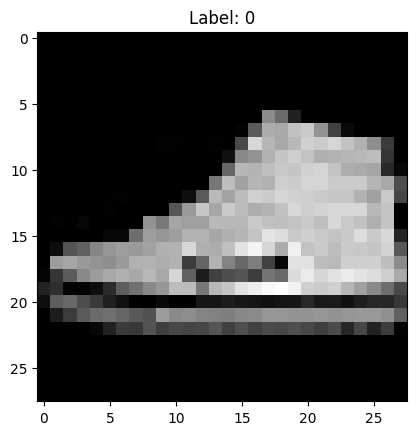

In [ ]:
# Mnist data checking
plt.imshow(Xtr_03[114, -1, :, :], cmap='gray') #[pic number,_,_,_]
plt.title(f"Label: {Str_03[0]}")
plt.show()

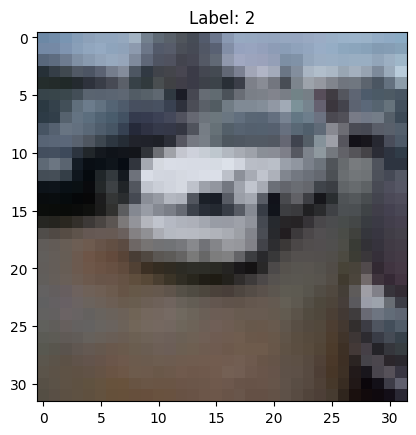

In [ ]:
# CIFAR data checking
mean_test = torch.tensor([0.4914, 0.4822, 0.4465], dtype=torch.float32).view(3, 1, 1)
std_test  = torch.tensor([0.2023, 0.1994, 0.2010], dtype=torch.float32).view(3, 1, 1)
test_cifar = Xtr_cifar[514] * std_test + mean_test
plt.imshow(np.transpose(test_cifar, (1, -1, 0)))
plt.title(f"Label: {Str_cifar[0]}")
plt.show()

In [23]:
class FixedTransition(nn.Module):
    def __init__(self, T: torch.Tensor):
        super().__init__()
        # 确保是 float32 且在正确 device
        T = T.detach().float()
        self.register_buffer("T", T)  # 不会被 optimizer 更新

    def forward(self):
        return self.T
def select_known_T(dataset_name: str):
    # 你的常量真 T（注意命名与设备）
    mnist03_T = torch.tensor([
        [0.7, 0.3, 0.0],
        [0.0, 0.7, 0.3],
        [0.3, 0.0, 0.7]
    ], dtype=torch.float32, device=device)

    mnist06_T = torch.tensor([
        [0.4, 0.3, 0.3],
        [0.3, 0.4, 0.3],
        [0.3, 0.3, 0.4]
    ], dtype=torch.float32, device=device)

    name = dataset_name.lower()
    if "3" in name or "mnist03" in name:
        return FixedTransition(mnist03_T)
    if "6" in name or "mnist06" in name:
        return FixedTransition(mnist06_T)
    return None  # 第三个数据集：未知 T

# Main Program

## Classifier: ResNet-34

In [24]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes,mode='cifar'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if mode == 'cifar':
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=0, bias=False)
        else:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, revision=True):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        out = self.linear(out)

        clean = F.softmax(out, 1)

        return clean

def ResNet34(num_classes,mode):
  return ResNet(BasicBlock, [1,1,1], num_classes,mode)

In [25]:
# ---------------------------
# transition matrix
# ---------------------------
class sig_t(nn.Module):
    def __init__(self, device, num_classes, init=2):
        super(sig_t, self).__init__()

        C = num_classes
        self.register_parameter(name='w', param=nn.parameter.Parameter(-init*torch.ones(num_classes, num_classes)))

        self.w.to(device)

        co = torch.full((C, C), 0.3, device=device)

        co.fill_diagonal_(0.4)

        self.co = co.to(device)
        self.identity = torch.eye(num_classes).to(device)


    def forward(self):
        sig = torch.sigmoid(self.w)
        T = self.identity.detach() + sig * self.co.detach()
        T = F.normalize(T, p=1, dim=1)
        return T

def logit(p, eps=1e-12):
    p = torch.clamp(p, eps, 1 - eps)
    return torch.log(p) - torch.log(1 - p)

In [26]:
def warmup(train_data, train_loader, model,optimizer_model, loss_func_ce):

    model.train()
    train_loss = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_model.zero_grad()

        clean = model(batch_x)

        ce_loss = loss_func_ce(clean.log(), batch_y.long())
        res = torch.mean(torch.sum(clean.log() * clean, dim=1))
        loss = ce_loss + res

        train_loss += loss.item()

        loss.backward()
        optimizer_model.step()


    print('Warmup Loss: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size))


def train(train_data, train_loader,model,trans_for,trans_back,optimizer_es,optimizer_trans_for,optimizer_trans_back,scheduler1,scheduler2,scheduler3,loss_func_ce):
    model.train()
    trans_back.train()

    T_true = select_known_T(Cfg.dataset)   # 前两数据集有，第三个为 None
    has_clean_T = T_true is not None

# forward 是否学习：有真T就不学；无真T要学
    if has_clean_T:
      trans_for.eval()
    else:
      trans_for.train()
    eps = 1e-8
    w_back = 0.7
    w_cycle =  0.3
    w_inv   = 0.3

    train_loss = 0.
    train_acc = 0.

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = torch.zeros(batch_x.size(0), Cfg.num_classes).scatter_(1, batch_y.view(-1,1), 1)
        batch_y = batch_y.to(device)

        clean = model(batch_x)
        noise = F.softmax(batch_y, 1)

        # === forward 矩阵 ===
        if has_clean_T:
            t_for_used = trans_for                     # 已经是常量张量
        else:
            t_for_used = trans_for()
            t_for_used = t_for_used / (t_for_used.sum(dim=0, keepdim=True) + eps)


        t_back = trans_back()             # 学习 backward

        out = torch.mm(clean, t_for_used).clamp_min(eps)
        out1 = torch.mm(noise, t_back).clamp_min(eps)

        noise_y = torch.max(noise, dim=1)[1].detach()
        clean_y = torch.max(clean, dim=1)[1].detach()

        ce_loss = loss_func_ce(out.log(), noise_y.long())
        ce_loss_1 =  loss_func_ce(out1.log(), clean_y.long())

        for_back_1 = torch.mm(clean, t_for_used.detach())
        for_back = torch.mm(for_back_1, t_back.detach()).clamp_min(eps)

        loss_for_back = loss_func_ce(for_back.log(), clean_y.long())  #loss_func_ce(for_back.log(), clean_y.long()) #-torch.mean(torch.sum(for_back.log() * clean,dim=1)) #

        I = torch.eye(Cfg.num_classes, device=device, dtype=torch.float32)
        R_inv = F.mse_loss(torch.mm(t_back, t_for_used), I) + F.mse_loss(torch.mm(t_for_used, t_back), I)

        # 总损失（forward 主导；backward / cycle / 互逆作正则）
        loss = ce_loss_1 + ce_loss + w_inv * R_inv# + w_cycle * loss_for_back

        train_loss += loss.item()

        pred = torch.max(out, 1)[1]
        train_correct = (pred == noise_y).sum()
        train_acc += train_correct.item()

        optimizer_es.zero_grad()
        optimizer_trans_for.zero_grad()
        optimizer_trans_back.zero_grad()

        loss.backward()

        optimizer_es.step()
        optimizer_trans_for.step()
        optimizer_trans_back.step()

    print('Train Loss: {:.6f},  Acc: {:.6f}'.format(train_loss / (len(train_data))*Cfg.batch_size,  train_acc / (len(train_data))))

    scheduler1.step()
    scheduler2.step()
    scheduler3.step()


def val(val_data, val_loader, model, trans, loss_func_ce):
    val_acc = 0.0
    val_loss_sum = 0.0
    total_n = 0

    with torch.no_grad():
        model.eval()
        trans.eval()

        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            clean = model(batch_x)                 # [B,C] 概率
            t = trans()                            # [C,C]

            # noisy one-hot
            noisy_1h = torch.zeros(batch_x.size(0), Cfg.num_classes, device=device) \
                         .scatter_(1, batch_y.view(-1,1), 1)

            # 估计 clean 标签（noisy -> t_back -> clean）
            est_clean = torch.mm(noisy_1h, t).clamp_min(1e-8)
            est_clean_y = est_clean.argmax(dim=1)

            # loss（注意：NLLLoss，log 前 clamp）
            loss = loss_func_ce(clean.clamp_min(1e-8).log(), est_clean_y.long())

            # 累加（按样本数加权平均）
            bs = batch_x.size(0)
            val_loss_sum += loss.item() * bs
            total_n += bs

            # 计算 acc：用模型的 clean 预测与估计的 clean 标签对齐
            pred_clean = clean.argmax(dim=1)
            val_acc += (pred_clean == est_clean_y).sum().item()

    avg_val_loss = val_loss_sum / total_n
    avg_val_acc  = val_acc / total_n
    print('Val Loss: {:.6f}, Acc: {:.6f}'.format(avg_val_loss, avg_val_acc))
    return avg_val_loss


def test(test_data, test_loader, model, loss_func_ce):
    eval_loss = 0.
    eval_acc = 0.

    with torch.no_grad():
        model.eval()

        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            clean = model(batch_x)

            loss = loss_func_ce(clean.clamp_min(1e-8).log(), batch_y.long())
            eval_loss += loss.item()
            pred = torch.max(clean, 1)[1]
            eval_correct = (pred == batch_y).sum()
            eval_acc += eval_correct.item()

        print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(test_data)) * Cfg.batch_size,
                                                      eval_acc / (len(test_data))))
    return eval_acc / (len(test_data))


In [27]:
def main(dataset_name):

      try:
          del model
      except:
          pass
      try:
          del trans; del trans_1
      except:
          pass
      gc.collect()
      if torch.cuda.is_available():
        torch.cuda.empty_cache()

      #init
      criterion = torch.nn.NLLLoss(reduction="mean")
      model = ResNet34(Cfg.num_classes,dataset_name)
      milestones = Cfg.milestones

      if dataset_name.lower() in ("mnist03"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.3.npz"))
      elif dataset_name.lower() in ("mnist06"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_mnist(*load_dataset("datasets/FashionMNIST0.6.npz"))
      elif dataset_name.lower() in ("cifar"):
          Xtr, ytr, Xva, yva, Xte, yte = reshape_cifar(*load_dataset("datasets/CIFAR.npz"))
      else:
          raise ValueError(f"Unsupported dataset: {dataset_name}")

      train_data = TensorDataset(Xtr, ytr)
      val_data = TensorDataset(Xva, yva)
      test_data = TensorDataset(Xte, yte)

      trans_known = select_known_T(dataset_name)                 # [MOD] FixedTransition(...) 或 None
      has_clean_T = trans_known is not None                      # [MOD]

          # === 初始化 transition 矩阵 ===
      if has_clean_T:                                            # [MOD]
          print(f"[Info] Using provided true transition matrix for {dataset_name}")  # [MOD]
          trans = trans_known                                    # [MOD] forward：直接用固定模块（可 .eval()/.train()）
          optimizer_trans = None                                  # [MOD] 有真 T 不需要优化器
          scheduler2 = None                                       # [MOD]
      else:
          trans = sig_t(device, Cfg.num_classes)                  # 原逻辑：forward 学习的 sig_t
          optimizer_trans = optim.AdamW(trans.parameters(), lr=Cfg.lr, weight_decay=0)
          scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)


      trans_1 = sig_t(device, Cfg.num_classes)
      #optimizer_trans = optim.AdamW(trans.parameters(), lr=Cfg.lr, weight_decay=0)
      optimizer_trans_1 = optim.AdamW(trans_1.parameters(), lr=Cfg.lr, weight_decay=0)


      #optimizer and StepLR
      optimizer_es = optim.AdamW(model.parameters(), lr=Cfg.lr, weight_decay=Cfg.weight_decay)
      scheduler1 = MultiStepLR(optimizer_es, milestones=milestones, gamma=0.1)
      #scheduler2 = MultiStepLR(optimizer_trans, milestones=milestones, gamma=0.1)
      scheduler3 = MultiStepLR(optimizer_trans_1, milestones=milestones, gamma=0.1)


      #data_loader
      train_loader = DataLoader(dataset=train_data,
                                batch_size=Cfg.batch_size,
                                shuffle=True,
                                num_workers=4,
                                drop_last=False)

      val_loader = DataLoader(dataset=val_data,
                              batch_size=Cfg.batch_size,
                              shuffle=False,
                              num_workers=4,
                              drop_last=False)

      test_loader = DataLoader(dataset=test_data,
                              batch_size=Cfg.batch_size,
                              num_workers=4,
                              drop_last=False)

      #cuda
      if torch.cuda.is_available():
          model = model.to(device)
          trans = trans.to(device)
          trans_1 = trans_1.to(device)


      best_acc = 0
      best_acc_back = 0
      #warmup
      for epoch in range(Cfg.warmup_epoch):
          print('epoch[{}], Warmup'.format(epoch + 1))
          warmup(train_data, train_loader, model,optimizer_es, criterion)
          val(val_data, val_loader, model, trans_1, criterion)
          acc = test(test_data, test_loader, model,criterion)
          if acc> best_acc:
              best_acc = acc
          print('Best_acc: {:.6f}'.format(best_acc))

      acc_list = []
      loss_list = []
      early_stop = 0
      best_val_acc = -10000

      #train
      for epoch in range(Cfg.n_epoch):
          print('epoch[{}], Train'.format(epoch+1))
          train(train_data,train_loader,model,trans,trans_1,optimizer_es,optimizer_trans,optimizer_trans_1,scheduler1,scheduler2,scheduler3,criterion)
          val_loss = val(val_data, val_loader, model, trans_1,criterion)
          acc = test(test_data, test_loader, model,criterion)

          acc_list.append(acc)
          loss_list.append(val_loss)


          if acc> best_acc and val_loss > best_val_acc:
              best_acc = acc
              best_val_acc = val_loss
              early_stop = 0
              print('Best_acc: {:.6f}'.format(best_acc))
          else:
              early_stop += 1
              print('Best_acc: {:.6f}'.format(best_acc))
              if early_stop >= Cfg.es_epoch:
                print(f"⏹ Early stopping at epoch {epoch+1} (best val_acc={best_acc:.6f})")
                break

      with torch.no_grad():
        Tf_np = trans().detach().cpu().numpy()
        Tb_np = trans_1().detach().cpu().numpy()

      print('Best_acc: ', best_acc)
      return best_acc,acc_list,loss_list,Tf_np, Tb_np


# Running

In [30]:
# ---------------------------
# Config
# ---------------------------
@dataclass
class Cfg:
    num_classes: int = 3
    dataset: str = "cifar"
    batch_size: int = 128
    lr: float = 0.01
    weight_decay: float = 1e-5
    milestones: Tuple[int, int] = (15, 30)
    lam: float = 0.6                 # weight for cycle term
    n_epoch: int = 120
    warmup_epoch: int = 10
    es_epoch: int = 30
    anchor: bool = False
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    lambda_T: float = 0.05
    beta_fc: float = 1.0

In [31]:
best,acc_list,loss_list ,Tf, Tb = main(Cfg.dataset)

epoch[1], Warmup
Warmup Loss: 0.047625
Val Loss: 1.100895, Acc: 0.344667
Test Loss: 1.105869, Acc: 0.367667
Best_acc: 0.367667
epoch[2], Warmup
Warmup Loss: 0.002383
Val Loss: 1.096221, Acc: 0.379667
Test Loss: 1.097853, Acc: 0.553333
Best_acc: 0.553333
epoch[3], Warmup
Warmup Loss: 0.000249
Val Loss: 1.096014, Acc: 0.352000
Test Loss: 1.105480, Acc: 0.363333
Best_acc: 0.553333
epoch[4], Warmup
Warmup Loss: -0.000334
Val Loss: 1.094356, Acc: 0.374000
Test Loss: 1.093787, Acc: 0.603333
Best_acc: 0.603333
epoch[5], Warmup
Warmup Loss: -0.001925
Val Loss: 1.094844, Acc: 0.367000
Test Loss: 1.101870, Acc: 0.429333
Best_acc: 0.603333
epoch[6], Warmup
Warmup Loss: -0.002030
Val Loss: 1.097851, Acc: 0.348333
Test Loss: 1.112649, Acc: 0.471667
Best_acc: 0.603333
epoch[7], Warmup
Warmup Loss: -0.002985
Val Loss: 1.093011, Acc: 0.384333
Test Loss: 1.092461, Acc: 0.566667
Best_acc: 0.603333
epoch[8], Warmup
Warmup Loss: -0.002590
Val Loss: 1.093366, Acc: 0.378667
Test Loss: 1.097250, Acc: 0.55400

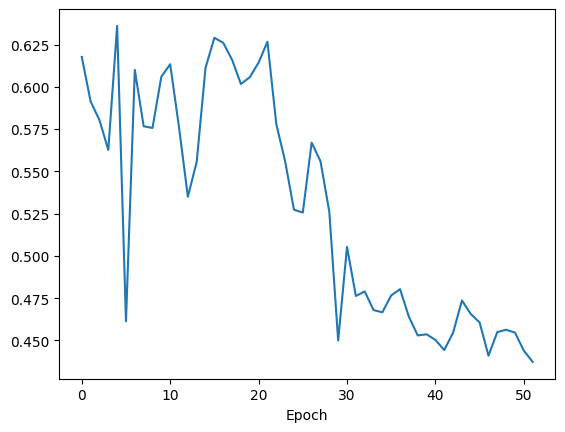

In [33]:
x_label = list(range(len(loss_list)))
plt.plot(x_label, acc_list)
plt.xlabel("Epoch")
plt.show()

In [38]:
print("\n=== Forward T (clean→noisy) ===")
print(np.array_str(Tf, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tf.sum(axis=1), 3))

print("\n=== Backward T (noisy→clean) ===")
print(np.array_str(Tb, precision=3, suppress_small=True, max_line_width=180))
print("row sums:", np.round(Tb.sum(axis=1), 3))


=== Forward T (clean→noisy) ===
[[0.936 0.032 0.032]
 [0.032 0.936 0.032]
 [0.032 0.032 0.936]]
row sums: [1. 1. 1.]

=== Backward T (noisy→clean) ===
[[0.722 0.13  0.148]
 [0.182 0.66  0.158]
 [0.166 0.121 0.713]]
row sums: [1. 1. 1.]
